## Isosplit
### Jeremy Maglund 2015
#### Unsupervised, non-parametric labeller
#### Code ported to python March 20-29, 2020, Kember/Sudarshan.

In [1]:
#from graphviz import Digraph
import collections
from collections import OrderedDict
import itertools as it
import gc
import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import seaborn as sns
from scipy.spatial import distance_matrix
from scipy.spatial import distance
from scipy.stats import norm
import math


#### class not used in this dev

In [2]:
#LABEL
class LABEL():
    def __init__(
        self,
        isocut_threshold = 1,
        min_cluster_size = 10,
        K_init = 200,
        refine_clusters = True,
        max_iterations_per_pass = 500,
        verbose = False,
        verbose_isocut = False,
        verbose_pause_duration = 0.5,
        whiten_cluster_pairs = True,
        initial_labels = np.array([]),
        prevent_merge = False,
        one_comparison_at_a_time = False,
        return_iterations = False,
        X = np.array([])
    ):
        
        self.isocut_threshold = isocut_threshold
        self.min_cluster_size = min_cluster_size
        self.refine_clusters = refine_clusters
        self.max_iterations_per_pass = max_iterations_per_pass
        self.verbose = verbose
        self.verbose_isocut = verbose_isocut
        self.verbose_pause_duration = verbose_pause_duration
        self.whiten_cluster_pairs = whiten_cluster_pairs
        self.initial_labels = initial_labels
        self.prevent_merge = prevent_merge
        self.one_comparison_at_a_time = one_comparison_at_a_time
        self.return_iterations = return_iterations
        self.X = X
        

# Compute the initial clusters        
    def call_neighbour_method(self):
    
        if np.size(self.initial_labels) == 0:
            print('call parcelate')
        else:
            print('call knn')
# Compute the cluster centers            
    def call_compute_center(self):
        print('call compute center')
    
# Repeat while something has been merged in the pass
    def call_merge(self):
        print('call merge')
        
# This is the result
# labels=data.labels;

#remap the labels to occupy the first natural numbers
    def call_remap(self):
        print('call remap')

#whiten_two_clusters_b
    def call_whiten_two_clusters_b(self):
        print('call whiten_two_clusters_b')

#whiten_two_clusters
    def call_whiten_two_clusters(self):
        print('call whiten_two_clusters')
        
#merge_test
    def call_merge_test(self):
        print('call merge_test')
        
#dists
    def call_dists(self):
        print('call dists')
        
#get_pairs_to_compare
    def call_get_pairs_to_compare(self):
        print('call get_pairs_to_compare')
        
#view_isocut_hist
    def call_view_isocut_hist(self):
        print('call view_isocut_hist')
        
#create_multimodal_nd
    def call_create_multimodal_nd(self):
        print('call create_multimodal_nd')
        
#generate_dataset
    def call_generate_dataset(self):
        print('call generate_dataset')
        
#test_isosplit5
    def call_test_isosplit5(self):
        print('call test_isosplit5')



#### initial parcelate code
##### code algorithm: changed to stop splitting below min parcel size (bug: Maglund: Matlab 2015)

In [3]:
def parcelate(X, min_parcel_size, max_parcels, split_factor, verbose=False) :
    """
    Parcelation
    -----------
    Created by: Jeremy Maglund
    Ported to python: March, 2020: Sudarshan/Kember

    input: X = [n_pts, dim]: rectangular numpy array
    max_parcels: maximum number of parcels (or clusters)
    min_parcel_size: parcels split down to minimum parcel size

    dynamic vars
    ------------
    parcel_n: current number of parcels: outer while loop
    this_parcel_index: index of current parcel: inner while loop

    parcels: unreachable entries 9 (int), -9.0 (float)
    -------
    parcel_indices: static: [max_parcels, n_pts] == [label-1 (for 0 start index), n_pts]
    parcel_centroids: static: [max_parcels, dim]
    parcel_radii: static: [max_parcels,]

    work vars:
    ----------
    crash_out: fail safe enforce split_factor >= min_cluster_size
    verbose: output verbosity
    this_parcel_index: index of current parcel
    parcel_n: parcel number (not index)
    something_changed: have self and points not self

    output: labels: static: [n_pts,]

    """
    #max number of parcels
    if verbose: print('max_parcels ',max_parcels)

    #min parcel size
    if verbose: print('min_parcel_size ',min_parcel_size)

    #split factor: typically split factor < min_parcel_size
    if verbose: print('split_factor ', split_factor)
        
    #must NOT have split_factor >= min_parcel_size
    #fail safe is embedded in code to prevent inadvertent override
    crash_out = False
    if split_factor >= min_parcel_size :
        crash_out = True
        print('********Violation of split_factor >= min_parcel_size*******',split_factor, min_parcel_size)
        
    if verbose: print('*************************')
    if verbose: print('*******START: INIT*******')
    if verbose: print('*************************')

    #init number of points n_pts and dimension dim
    [n_pts, dim] = np.shape(X)
    if verbose: print('n_pts, dim',n_pts, dim)

    #init number of parcels
    parcel_n = 1

    #init current parcel
    this_parcel_index = 0

    #init labels
    labels = np.full(n_pts, -9)

    #get indices of parcel (all points for init)
    parcel_indices = np.full([max_parcels, n_pts], -9)
    parcel_indices[this_parcel_index] = np.arange(n_pts)
    if verbose: print('indices: this_parcel_index, this_parcel indices ',this_parcel_index, parcel_indices[this_parcel_index])

    #get centroid of initial parcel (all points for init)
    parcel_centroids = np.full([max_parcels, dim],-9.0)
    parcel_centroids[this_parcel_index] = np.mean(np.transpose(X),axis=1)
    if verbose: print('centroids: this_parcel_index, this_parcel_centroid ',this_parcel_index, parcel_centroids[this_parcel_index])

    #get radius of a parcel (all points for init)
    parcel_radii = np.full(max_parcels, -9.0)
    parcel_radii[this_parcel_index] = np.max(np.sqrt(np.sum((X - parcel_centroids[this_parcel_index])**2,axis=1)))
    if verbose: print('radii: this_parcel_index, this_parcel_radius ',this_parcel_index, parcel_radii[this_parcel_index])

    if verbose: print('num parcels max parcels ',parcel_n, max_parcels)

    if verbose: print('**********************')
    if verbose: print('*******END INIT*******')
    if verbose: print('**********************')

    while parcel_n < max_parcels and not crash_out :
        if verbose: print('OUTSIDE WHILE LOOP: parcel_n max_parcels', parcel_n, max_parcels)
        if verbose: print('OUTSIDE WHILE LOOP EXECUTION: depends on size of split_factor reduction')

        #global number of indices in each parcel
        parcel_sizes = np.sum(parcel_indices > -9,axis=1)
        parcel_sizes = parcel_sizes[np.nonzero(parcel_sizes > 0)[0]]
        if verbose: print('sizes ',parcel_sizes)

        #global check if cannot split
        if np.sum(parcel_radii > 0.0) and np.sum((parcel_sizes > min_parcel_size)) == 0 :
            break

        if verbose: print('parcel radii ', parcel_radii)
        # set target radius ~ largest parcel radius exceeding min_parcel_size
        target_radius = np.max(parcel_radii[np.nonzero(parcel_sizes > min_parcel_size)[0]]) * 0.95
        if verbose: print('target radius ',target_radius)

        # step through each parcel
        something_changed = False

        #start at zero index parcel
        this_parcel_index = 0

        while this_parcel_index < parcel_n and not crash_out :
            if verbose: print('\t INSIDE WHILE LOOP this_parcel_index < num_parcels ', this_parcel_index, parcel_n)
            if verbose: print('\n split factor reduction: overwrite 1 parcel: create split_factor - 1 NEW PARCELS')

            #list of parcel indices
            inds = parcel_indices[this_parcel_index][np.nonzero(parcel_indices[this_parcel_index] > -9)[0]]
            if verbose: print('\t inds ', inds)

            #single value: number of indices in parcel
            parcel_size = len(inds)
            if verbose: print('\t size', parcel_size)

            #single value
            rad = parcel_radii[this_parcel_index]
            if verbose: print('\t this radius ',rad)

            #see if need to split
            if parcel_size > min_parcel_size and rad >= target_radius and not crash_out :

                if verbose: print('\t \t IF: parcel_size > minparcel and rad >= target_radius', parcel_size, min_parcel_size, rad, target_radius)
                # the parcel has more than the tnarget number of points and is larger than the target radius                
                iii = np.arange(split_factor).tolist()
                if verbose: print('\t \t iii is ',iii)

                #distance from split_factor list -> to -> all members: dm = [split_factor, inds members]
                dm = distance_matrix(X[inds[iii], :], X[inds, :])
                if verbose: print('\t \t dm \n',dm)


                #find indices of parcel members closest to test set inds[iii]
                assignments = np.argmin(dm, axis=0)
                if verbose: print('\t \t assignments ', assignments)

                # make sure not everything got assigned to 1 and there were self = 0 distances
                if np.sum(assignments > 0) > 0 and np.sum(assignments == 0) > 0 and not crash_out :
                    if verbose: print('\t \t \t some self but not everything: so do split ')

                    if verbose: print('\t \t \t START: assign == 0 ')

                    #is a need to split
                    something_changed = True
                    if verbose: print('\t \t \t **SOMETHING CHANGED**  ',something_changed)

                    #over write this_parcel_index with those parcel locations closest to self
                    this_parcel_indices = inds[np.nonzero(assignments == 0)[0]]

                    #overwrite whole parcel as -9 for rewrite
                    parcel_indices[this_parcel_index] = -9
                    parcel_indices[this_parcel_index][this_parcel_indices] = this_parcel_indices
                    if verbose: print('\t \t \t \t this parcel this_parcel_indices ',this_parcel_index, parcel_indices[this_parcel_index])

                    #reset centroid
                    parcel_centroids[this_parcel_index] = np.mean(np.transpose(X)[:, this_parcel_indices],axis=1)
                    if verbose: print('\t \t \t \t this parcel centroid ',this_parcel_index, parcel_centroids[this_parcel_index])

                    #reset radius
                    parcel_radii[this_parcel_index] = np.max(np.sqrt(np.sum((X[this_parcel_indices, :] - parcel_centroids[this_parcel_index])**2,axis=1)))
                    if verbose: print('\t \t \t \t this parcel radii ',this_parcel_index, parcel_radii[this_parcel_index])

                    #reset label
                    labels[this_parcel_indices] = this_parcel_index + 1
                    if verbose: print('\t \t \t \t labels ', labels)

                    if verbose: print('\t \t \t END: assign == 0 ')

                    #create split_factor - 1 NEW PARCELS due to split assignments
                    if verbose: print('\t \t \t START FOR LOOP: NEW PARCEL: assign ~= 0 ')
                    if verbose: print('\t \t \t global inds ', inds)
                    for jj in np.arange(1, split_factor) :
                        next_inds = inds[np.nonzero(assignments == jj)[0]]
                        if verbose: print('\t \t \t \t assignments jj parcel_n next inds ',jj, parcel_n, next_inds)
                        parcel_indices[parcel_n][next_inds] = next_inds
                        parcel_centroids[parcel_n] = np.mean(np.transpose(X)[:, next_inds],axis=1)
                        if verbose: print('\t \t \t \t jj centroids ', parcel_centroids[parcel_n])
                        parcel_radii[parcel_n] = np.max(np.sqrt(np.sum((X[next_inds, :] - parcel_centroids[parcel_n])**2,axis=1)))
                        if verbose: print('\t \t \t \t jj radii ', parcel_radii[parcel_n])
                        #set number of parcels - after the above - indexing is 1 lower
                        parcel_n = parcel_n + 1
                        labels[next_inds] = parcel_n

                        if parcel_n >= max_parcels:
                            print('\t \t \t \t ******PARCELATE: BAD APPEND******: split_factor <= max_parcels')
                            crash_out = True
                            break

                        if verbose: print('\t \t \t \t jj labels',jj, labels)                    

                    if verbose: print('\t \t \t DONE FOR LOOP: NEW PARCEL: assign ~= 0 ')

                else :
                    warning('There was an issue splitting a parcel. This could result from the same point being included multiple times in the data.');

            else :
                this_parcel_index = this_parcel_index + 1
                if verbose: print('\t size and radius ok: go to next parcel **SOMETHING CHANGED**  ', this_parcel_index, something_changed)

        if not something_changed :
            if verbose: print('\t could not split **SOMETHING CHANGED** ', something_changed)
            break

    return labels


# isosplit/cut routines ported to python

### jisotonic regression matlab version

In [4]:
#in Maglund this part is called as part of jisotonic5
#we have added a calling routine for clarity rather than use recursive function
#function jisotonic5(A, weights)
#    %assume increasing
#    X=cell(1,0);
#    N=length(A);

#    tmp.unweightedcount=1;
#    tmp.count=weights(1);
#    tmp.sum=A(1)*weights(1);
#    tmp.sumsqr=A(1)^2*weights(1);
#    lastind=1;
#    X{lastind}=tmp;

#    MSEs=zeros(1,N);
#    MSEs(1)=0;

#    for j=2:N
    #    tmp.unweightedcount=1;
    #    tmp.count=weights(j);
    #    tmp.sum=A(j)*weights(j);
    #    tmp.sumsqr=A(j)^2*weights(j);
    #    X{lastind+1}=tmp;
    #    MSEs(j)=MSEs(j-1);
    #    lastind=lastind+1;

    #    while true
    #        if (lastind<=1) 
    #            break; 
    #        end
    #        tmp1=X{lastind-1};
    #        tmp2=X{lastind};
    #        prevMSE=tmp1.sumsqr-tmp1.sum^2/tmp1.count + tmp2.sumsqr-tmp2.sum^2/tmp2.count;
    #        if (tmp1.sum/tmp1.count<tmp2.sum/tmp2.count)
    #            break;
    #        else
    #            tmp.unweightedcount=tmp1.unweightedcount+tmp2.unweightedcount;
    #            tmp.count=tmp1.count+tmp2.count;
    #            tmp.sum=tmp1.sum+tmp2.sum;
    #            tmp.sumsqr=tmp1.sumsqr+tmp2.sumsqr;
    #            X{lastind-1}=tmp;
    #            lastind=lastind-1;
    #            newMSE=tmp.sumsqr-tmp.sum^2/tmp.count;
    #            MSEs(j)=MSEs(j)+newMSE-prevMSE;
    #        end
    #    end
#    end

#    B=zeros(1,N);
#    ii=1;
#    for k=1:lastind
    #    tmp0=X{k};
    #    for cc=1:tmp0.unweightedcount
    #        B(ii+cc-1)=tmp0.sum/tmp0.count;
    #    end
    #    ii=ii+tmp0.unweightedcount;
#    end

#end


### jisotonic regression python version

In [5]:
def jisotonic5(A, weights, verbose=False) :
    """
    jisotonic5: isotonic regression cases
   
    A: input vector
        
    weights: optional A element weight vec
    
    B: output vector
    
    MSEs: external work var 'updown/downup'
    """

    if verbose: print('*******jisotonic5: weights******* ',weights)
    #init
    N = len(A)
    
    unwct = np.full(N, -9)
    count = np.full(N, -9.0)
    sumit = np.full(N, -9.0)
    sumsq = np.full(N, -9.0)
    
    
    #init: [unweightedcount, count, sum, sumsqr]
    #use 5 letter names for algorithm symmetry [unwct, count, sumit, sumsq]
    last = 0
    unwct[last] = 1
    count[last] = weights[0]
    sumit[last] = A[0] * weights[0]
    sumsq[last] = A[0] * A[0] * weights[0]

    MSEs=np.full(N, 0.0)

    #
    for j in np.arange(1, N) :
        #
        last = last + 1 
        #
        unwct[last] = 1
        #
        count[last] = weights[j]
        #
        sumit[last] = A[j] * weights[j]
        #
        sumsq[last] = A[j] * A[j] * weights[j]
        #
        MSEs[j] = MSEs[j-1]

        if verbose: print('for: update: last, count[last] ', last, count[last])
        
        #
        while True :
            #
            if last <= 0 :
                break

            #
            prevMSE = sumsq[last-1] - np.square(sumit[last-1]) / count[last-1] + sumsq[last] - np.square(sumit[last]) / count[last]

            #
            if sumit[last-1] / count[last-1] < sumit[last] / count[last] :
                break
                
            #
            else :

                #
                unwct[last-1] = unwct[last-1] + unwct[last]
                count[last-1] = count[last-1] + count[last]
                sumit[last-1] = sumit[last-1] + sumit[last]
                sumsq[last-1] = sumsq[last-1] + sumsq[last]
                if verbose: print('for: update count[last-1] ', count[last-1])
                #
                newMSE = sumsq[last-1] - sumit[last-1] * sumit[last-1] / count[last-1]

                #
                last = last - 1

                #
                MSEs[j] = MSEs[j] + newMSE - prevMSE

    #
    B = np.full(N, 0.0)
    
    #
    ii = 0

    #inclusive on last: last + 1
    for k in np.arange(0, last + 1) :
    
        #self average
        for cc in np.arange(0, unwct[k]) :
        
            #
            B[ii+cc] = sumit[k] / count[k]
        
        #update ii after self average complete
        ii = ii + unwct[k]

    return B, MSEs


### python: partial jisotonic5 test: details

In [6]:
#test jisotonic5 results on increasing case
np.set_printoptions(precision=2)
A = np.array([1.1,3.2,5.3,2.4,4.5,6.6,3.7,5.8,7.9,10.0,9.2,11.2,7.3,3.4,5.5,2.6,3.7,1.8])
weights = np.ones(len(A))
[B, MSEs] = jisotonic5(A, weights,verbose=True)
A, weights, B, MSEs

*******jisotonic5: weights*******  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
for: update: last, count[last]  1 1.0
for: update: last, count[last]  2 1.0
for: update: last, count[last]  3 1.0
for: update count[last-1]  2.0
for: update: last, count[last]  3 1.0
for: update: last, count[last]  4 1.0
for: update: last, count[last]  5 1.0
for: update count[last-1]  2.0
for: update: last, count[last]  5 1.0
for: update: last, count[last]  6 1.0
for: update: last, count[last]  7 1.0
for: update: last, count[last]  8 1.0
for: update count[last-1]  2.0
for: update: last, count[last]  8 1.0
for: update: last, count[last]  9 1.0
for: update count[last-1]  2.0
for: update count[last-1]  4.0
for: update: last, count[last]  8 1.0
for: update count[last-1]  5.0
for: update: last, count[last]  8 1.0
for: update count[last-1]  6.0
for: update count[last-1]  7.0
for: update: last, count[last]  7 1.0
for: update count[last-1]  8.0
for: update: last, count[last]  7 1.0
for: update count[last

(array([ 1.1,  3.2,  5.3,  2.4,  4.5,  6.6,  3.7,  5.8,  7.9, 10. ,  9.2,
        11.2,  7.3,  3.4,  5.5,  2.6,  3.7,  1.8]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.]),
 array([1.1 , 3.2 , 3.85, 3.85, 4.5 , 5.15, 5.15, 5.8 , 6.26, 6.26, 6.26,
        6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26]),
 array([  0.  ,   0.  ,   0.  ,   4.21,   4.21,   4.21,   8.41,   8.41,
          8.41,   8.41,   8.73,   8.73,  16.46,  45.5 ,  51.68,  75.21,
         85.71, 107.81]))

### matlab call jisotonic regression recursively: we don't do that

In [7]:
#in Maglund jisotonic5 is recursive
#we use an actual calling function
#function [B,MSEs]=jisotonic5(A,direction,weights)
#% jisotonic5 - isotonic regression (jfm, may 2015)
#%
#% [B,MSEs] = jisotonic5(A,direction,weights)
#%   A is the input vector
#%   direction = 'increasing', 'decreasing', 'updown', or 'downup'
#%   weights is the optional input weight vector (same size as A)
#%   B is the output vector (same size as A)
#%   MSEs is used internally for 'updown' and 'downup' directions
#%
#% Magland 5/19/2015

#if (nargin<1)
#    jisotonic5_test; %run the test code
#    return;
#end;
#if (nargin<2)
#    direction='increasing';
#end;
#if (~isrow(A)) A=A'; end;
#if (nargin<3)
#    weights=ones(size(A));
#end;

#if (strcmp(direction,'decreasing'))
#    [B,MSEs]=jisotonic5(-A,'increasing',weights);
#    B=-B;
#    return;
#elseif (strcmp(direction,'updown'))
#    [B1,MSE1]=jisotonic5(A,'increasing',weights);
#    [B2,MSE2]=jisotonic5(A(end:-1:1),'increasing',weights(end:-1:1));
#    B2=B2(end:-1:1);
#    MSE2=MSE2(end:-1:1);
#    MSE0=MSE1+MSE2;

#    [~,best_ind]=min(MSE0);
#    C1=jisotonic5(A(1:best_ind),'increasing',weights(1:best_ind));
#    C2=jisotonic5(A(best_ind:end),'decreasing',weights(best_ind:end));
#    B=[C1(1:best_ind),C2(2:end)];
#    if (isnan(B(1)))
#        warning('jisotonic5: NaN');
#    end;
#    return;
#elseif (strcmp(direction,'downup'))
#    B=-jisotonic5(-A,'updown',weights);
#    return;
#    else
#    if (~strcmp(direction,'increasing'))
#        error(['invalid direction in jisotonic5: ',direction]);
#        return;
#    end;
#end;

### python: call jisotonic5 regression: each case separate: no recursion

In [8]:
def call_jisotonic5(A, direction, weights, verbose=False) :
    """
    call_jisotonic5: isotonic regression cases

    jisotonic5(A, direction)
    
    A: input vector
    
    direction: 'increasing', 'decreasing', 'updown', or 'downup'
    
    weights: optional A element weight vec
    
    B is the output vector (same size as A)

    MSEs: 'updown' and 'downup'
    """
    N = len(A)

    #set default if needed
    if weights is None: 
        weights = np.ones(N)
    
    if direction == 'increasing' :
        if verbose: print('direction ', direction)
        [B, _] = jisotonic5(A, weights, verbose)
        return B
    #
    elif direction == 'decreasing' :
        if verbose: print('direction ', direction)
        
        #flip sign of A
        [B, _] = jisotonic5(-A, weights, verbose)
        
        #flip sign of B
        return -B
    #
    elif direction == 'updown' :
        if verbose: print('direction ', direction)

        #sign of A unchanged

        #A increasing
        [B1, MSE1] = jisotonic5(A, weights, verbose)
        
        #flip A increasing
        [B2, MSE2] = jisotonic5(np.flip(A), np.flip(weights), verbose)
        
        #flip B2
        B2 = np.flip(B2)
        
        #flip MSE2
        MSE2 = np.flip(MSE2)
        MSE0 = MSE1 + MSE2
        
        #MSE1 and MSE2: monotonic increasing/decreasing
        #sum(MSE1 + MSE2) possesses a global min
        #set breakpoint between up-down
        best_ind = np.argmin(MSE0)

        #match matlab inclusive
        best_ind = best_ind + 1
        
        #fit up
        [C1, _] = jisotonic5(A[0:best_ind],weights[0:best_ind], verbose)
        
        #fit down: decreasing: flip sign of A: share min
        [C2, _] = jisotonic5(-A[best_ind-1:],weights[best_ind-1:], verbose)
        
        #flip sign of C2
        C2 = -C2
        
        #
        B = np.concatenate([C1[0:best_ind],C2[1:]], axis=0)
        if np.isnan(B[0]) :
            print('WARNING: downup: jisotonic5: NaN')
        
        #sign of B unchanged
        return B
        
    #
    elif direction == 'downup' :
        if verbose: print('direction ', direction)

        #flip sign of A: then repeat updown approach
        A = -A
        
        #repeat updown as downup

        #A increasing
        [B1, MSE1] = jisotonic5(A, weights, verbose)
        
        #flip A increasing
        [B2, MSE2] = jisotonic5(np.flip(A), np.flip(weights), verbose)
        
        #flip B2
        B2 = np.flip(B2)
        
        #flip MSE2
        MSE2 = np.flip(MSE2)
        MSE0 = MSE1 + MSE2
        
        #MSE1 and MSE2: monotonic increasing/decreasing
        #sum(MSE1 + MSE2) possesses a global min
        #set breakpoint between up-down
        best_ind = np.argmin(MSE0)

        #match matlab inclusive
        best_ind = best_ind + 1
        
        #fit up
        [C1, _] = jisotonic5(A[0:best_ind],weights[0:best_ind], verbose)
        
        #fit down: decreasing: flip sign of A: share min
        [C2, _] = jisotonic5(-A[best_ind-1:],weights[best_ind-1:], verbose)
        
        #flip sign of C2
        C2 = -C2
        
        #
        B = np.concatenate([C1[0:best_ind],C2[1:]], axis=0)
        if np.isnan(B[0]) :
            print('WARNING: downup: jisotonic5: NaN')
        
        #flip sign of B on return since doing downup
        return -B        
    #
    else :
        print('WARNING: bad direction: call_jisotonic5 ')
        return np.array([])
        
    
    return


### matlab jisotonic5 test

In [9]:
#function jisotonic5_test

#A=[1.1,3.2,5.3,2.4,4.5,6.6,3.7,5.8,7.9,10.0,9.2,11.2,7.3,3.4,5.5,2.6,3.7,1.8];
#fprintf('\n done increasing');
#[BB,BMSE]=jisotonic5(A);
#BB
#fprintf('\n done B');
#[CC,CMSE]=jisotonic5(A,'decreasing');
#fprintf('\n done decreasing');
#CC
#DD=jisotonic5(A,'updown');
#fprintf('\n done updown');
#DD
#EE=jisotonic5(A,'downup');
#fprintf('\n done downup');
#EE

#don't need plots: but helpful to see what's going on: pretty simple
#%figure; plot(1:length(A),A,'b',1:length(B),B,'or',1:length(C),-C,'x-g',1:length(D),D,'k'); grid on; 
#%figure; plot(1:length(BMSE),BMSE,'.-k'); grid on; 

#end

### python: full jisotonic5 test

In [10]:
verbose = True
A = np.array([1.1,3.2,5.3,2.4,4.5,6.6,3.7,5.8,7.9,10.0,9.2,11.2,7.3,3.4,5.5,2.6,3.7,1.8])
weights = np.ones(len(A))

print('built A')

BB = call_jisotonic5(A, 'increasing', weights, verbose)
print('increasing results ')
print('BB ', BB )

CC = call_jisotonic5(A,'decreasing', weights, verbose);
print('decreasing results ')
print('CC ', CC )


DD=call_jisotonic5(A,'updown', weights, verbose)
print('updown results ')
print('DD ', DD )

EE=call_jisotonic5(A,'downup', weights, verbose)
print('downup results ')
print('EE ', EE )


built A
direction  increasing
*******jisotonic5: weights*******  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
for: update: last, count[last]  1 1.0
for: update: last, count[last]  2 1.0
for: update: last, count[last]  3 1.0
for: update count[last-1]  2.0
for: update: last, count[last]  3 1.0
for: update: last, count[last]  4 1.0
for: update: last, count[last]  5 1.0
for: update count[last-1]  2.0
for: update: last, count[last]  5 1.0
for: update: last, count[last]  6 1.0
for: update: last, count[last]  7 1.0
for: update: last, count[last]  8 1.0
for: update count[last-1]  2.0
for: update: last, count[last]  8 1.0
for: update: last, count[last]  9 1.0
for: update count[last-1]  2.0
for: update count[last-1]  4.0
for: update: last, count[last]  8 1.0
for: update count[last-1]  5.0
for: update: last, count[last]  8 1.0
for: update count[last-1]  6.0
for: update count[last-1]  7.0
for: update: last, count[last]  7 1.0
for: update count[last-1]  8.0
for: update: last, count[last]

### compute ks5

#### matlab computeks5 and ks

In [11]:
#compute ks5
#function [best_ks,best_len]=compute_ks5(counts1,counts2)
#len=length(counts1);
#best_ks=-inf;
#while (len>=4)||(len==length(counts1))
#    ks=compute_ks4(counts1(1:len),counts2(1:len));
#    if (ks>best_ks)
#        best_ks=ks;
#        best_len=len;
#    end;
#    len=floor(len/2);
#end;
#function [ks]=compute_ks4(counts1,counts2)
#S1=cumsum(counts1)/sum(counts1);
#S2=cumsum(counts2)/sum(counts2);
#ks=max(abs(S1-S2));
#ks=ks*sqrt((sum(counts1)+sum(counts2))/2);


#### python computeks5 and ks
##### has initial=0 ks value in case no max exists

In [12]:
def compute_ks5(counts1, counts2, verbose=False) :
    #print('****inside ks5****')
    #[:0] returns empty[]: require + 1 for [:1] min
    #also while loop uses len(counts1) >= 1
    N1 = len(counts1)
    best_ks = -np.Inf
    #print('N1 best_ks ',N1, best_ks)
    #print('len, counts 1',N1, counts1)
#    print('*****ks5 np.sum(counts1[:N1])*****', np.sum(counts1[:N1]))
#    print('*****ks5 np.sum(counts2[:N1])*****', np.sum(counts2[:N1]))
    while  N1 >= 4 or N1 == len(counts1):
#        print('start of while: N1 ', N1)
        ks = np.max(np.abs(np.cumsum(counts1[:N1])/np.sum(counts1[:N1]) - np.cumsum(counts2[:N1])/np.sum(counts2[:N1]))) * \
                np.sqrt((np.sum(counts1) + np.sum(counts2)) / 2)
        if ks > best_ks :
            best_ks = ks
            best_N1 = N1
            #print('inside if: best_ks best_N1 ',best_ks, best_N1)
        N1 = math.floor(N1/2)
    #print('****best_ks N1****',best_ks, best_N1)
    return best_ks, best_N1

In [13]:
math.floor(0.5)

0

In [14]:
counts1 = np.array([1,2,3,4,5,6,7,8,9,9])
counts2 = np.array([1,2,3,4,5,8,7,8,10,9])
[best_ks, best_N1] = compute_ks5(counts1, counts2, verbose=True)
best_ks, best_N1

(0.10891567562683747, 10)

### isocut5 main matlab version

In [15]:
#isocut5.m: all plot and info code has been stripped
#function [dip_score,cutpoint,info]=isocut5(samples,sample_weights,opts)

#[~,N]=size(samples);
#if (N==0)
#    error('Error in isocut5: N is zero.');
#end;
#num_bins_factor=opts.num_bins_factor;
#num_bins=ceil(sqrt(N/2)*num_bins_factor);

#if (length(sample_weights)==0), sample_weights=ones(1,N); end;

#if (opts.already_sorted)
#    X=samples;
#else
#    [X,sort_inds]=sort(samples);
#    sample_weights=sample_weights(sort_inds);
#end;

#while 1
#    num_bins_1=ceil(num_bins/2);
#    num_bins_2=num_bins-num_bins_1;
#    intervals=[1:num_bins_1,num_bins_2:-1:1];
#    alpha=(N-1)/sum(intervals);
#    intervals=intervals*alpha;
#    inds=floor([1,1+cumsum(intervals)]);
#    N_sub=length(inds);
#    if (min(intervals)>=1)
#        break;
#    else
#        num_bins=num_bins-1;
#    end;
#end;

#cumsum_sample_weights=cumsum(sample_weights);

#X_sub=X(inds);
#spacings=X_sub(2:end)-X_sub(1:end-1);
#multiplicities=cumsum_sample_weights(inds(2:end))-cumsum_sample_weights(inds(1:end-1));
#densities=multiplicities./spacings;

#densities_unimodal_fit=jisotonic5(densities,'updown',multiplicities);

#[~,peak_density_ind]=max(densities_unimodal_fit); peak_density_ind=peak_density_ind(1);
#[ks_left,ks_left_index]=compute_ks5(multiplicities(1:peak_density_ind),densities_unimodal_fit(1:peak_density_ind).*spacings(1:peak_density_ind));
#[ks_right,ks_right_index]=compute_ks5(multiplicities(end:-1:peak_density_ind),densities_unimodal_fit(end:-1:peak_density_ind).*spacings(end:-1:peak_density_ind));
#ks_right_index=length(spacings)-ks_right_index+1;

#if (ks_left>ks_right)
#    critical_range=1:ks_left_index;
#    dip_score=ks_left;
#else
#    critical_range=ks_right_index:length(spacings);
#    dip_score=ks_right;
#end;

#densities_resid=densities-densities_unimodal_fit;
#densities_resid_fit=jisotonic5(densities_resid(critical_range),'downup',spacings(critical_range));
#[~,cutpoint_ind]=min(densities_resid_fit); cutpoint_ind=cutpoint_ind(1);
#cutpoint_ind=critical_range(1)+cutpoint_ind-1;
#cutpoint=(X_sub(cutpoint_ind)+X_sub(cutpoint_ind+1))/2;


#function [ks]=compute_ks4(counts1,counts2)
#S1=cumsum(counts1)/sum(counts1);
#S2=cumsum(counts2)/sum(counts2);
#ks=max(abs(S1-S2));
#ks=ks*sqrt((sum(counts1)+sum(counts2))/2);

#function [best_ks,best_len]=compute_ks5(counts1,counts2)
#len=length(counts1);
#best_ks=-inf;
#while (len>=4)||(len==length(counts1))
#    ks=compute_ks4(counts1(1:len),counts2(1:len));
#    if (ks>best_ks)
#        best_ks=ks;
#        best_len=len;
#    end;
#    len=floor(len/2);
#end;

#function [counts,bins]=hist_with_weights(X,weights,num_bins)
#bin_width=(max(X(:))-min(X(:)))/num_bins;
#bin_ints=round(X/bin_width);
#i1=min(bin_ints);
#i2=max(bin_ints);
#bins=(i1:i2)*bin_width;
#ii=bin_ints-i1+1;
#counts=accumarray(ii',weights',[length(bins),1]);



### isocut 5 python version

In [16]:
def isocut5(samples, sample_weights, num_bins_factor=1, already_sorted=False, verbose=False) :
    
    ks5_verbose=False
        
    N = len(samples)
    if N == 0 :
        print('WARNING: error in isocut5: N is zero.')
        dip_score = -9.0
        cutpoint = -9.0
        return dip_score, cutpoint
    
    num_bins = math.ceil(np.sqrt(N/2) * num_bins_factor)
    if verbose: print('num_bins ',num_bins)
    
    if already_sorted :
        X = samples
    else :
        sort_inds = np.argsort(samples)
        X = samples[list(sort_inds)]
        sample_weights = sample_weights[list(sort_inds)]
    
    if verbose: print('X sorted ', X)
    if verbose: print('sample weights ', sample_weights)
    while 1 :
        num_bins_1 = math.ceil(num_bins/2)
        num_bins_2 = num_bins - num_bins_1
        if verbose: print('numbin 1 2 ',num_bins_1, num_bins_2)
        #intervals=[1:num_bins_1,num_bins_2:-1:1]
        intervals = np.concatenate([np.arange(num_bins_1)+1, np.flip(np.arange(num_bins_2))+1])
        if verbose: print('intervals ',intervals)
        if verbose: print('*****intervals sum*****', np.sum(intervals))
        alpha = (N-1)/np.sum(intervals)
        if verbose: print('alpha ',alpha)
        intervals = intervals*alpha
        if verbose: print('intervals ', intervals)
        inds = 1.0 + np.cumsum(intervals)
        inds = np.floor(np.insert(inds, 0, 1.0, axis=0)).astype(int)
        if verbose: print('inds ',inds)
        N_sub = len(inds)
        if verbose: print('N_sub ',N_sub)
        if np.min(intervals) >= 1 :
            break
    else :
        num_bins = num_bins - 1
        
    cumsum_sample_weights = np.cumsum(sample_weights)
    if verbose: print('cumsum sample weights ',cumsum_sample_weights)
    X_sub = X[inds - 1]
    if verbose: print('X_sub ', X_sub)
    spacings = X_sub[1:] - X_sub[:-1]
    if verbose: print('spacings ', spacings)
    mults = cumsum_sample_weights[list(inds[1:] - 1)] - cumsum_sample_weights[list(inds[:-1] - 1)];
    if verbose: print('multiplicities ', mults)
    densities = np.divide(mults, spacings)
    if verbose: print('densities ', densities)

    densities_unimodal_fit = call_jisotonic5(densities, 'updown', mults)
    if verbose: print('densities_unimodal fit ',densities_unimodal_fit)
        
    peak_density_ind = np.argmax(densities_unimodal_fit)
    if verbose: print('peak_density_ind ',peak_density_ind)
    if verbose: print('mults left call [: peak_density_ind]',mults[:peak_density_ind + 1])
    [ks_left,ks_left_index] =\
            compute_ks5(mults[:peak_density_ind + 1],\
                                np.multiply(densities_unimodal_fit[:peak_density_ind + 1],\
                                            spacings[:peak_density_ind + 1]), ks5_verbose\
                   )
    if verbose: print('ks left left_index',ks_left, ks_left_index)
    if verbose: print('mults right call [: peak_density_ind]',np.flip(mults)[:len(mults)-peak_density_ind])
    #was: mults[-1:peak_density_ind - 1:-1] fails on peak_density_ind = 0
    #compute_ks5(mults[-1:peak_density_ind - 1:-1],\
    #np.flip(peaktest)[:len(peaktest)-peakind]
    [ks_right, ks_right_index] =\
            compute_ks5(np.flip(mults)[:len(mults)-peak_density_ind],\
                        np.multiply(np.flip(densities_unimodal_fit)[:len(mults)-peak_density_ind],\
                                np.flip(spacings)[:len(mults)-peak_density_ind]), ks5_verbose\
                   )
    ks_right_index = len(spacings) - ks_right_index + 1
    if verbose: print('ks right right_index',ks_right, ks_right_index)

    
    if ks_left > ks_right :
        if verbose: print('left > right ')
        critical_range = np.arange(ks_left_index)
        dip_score = ks_left
    else :
        if verbose: print('left <= right len(spacings) ',len(spacings))
        critical_range = np.arange(len(spacings) -(ks_right_index - 1)) + (ks_right_index - 1)
        dip_score = ks_right
    if verbose: print('dip critical range ',dip_score, critical_range)
    
    densities_resid = densities - densities_unimodal_fit
    if verbose: print('densities_resid ',densities_resid)
    if verbose: print('dens_resid[crit range]',densities_resid[critical_range])
    densities_resid_fit = call_jisotonic5(densities_resid[critical_range],'downup',spacings[critical_range])
    if verbose: print('dens_resid_fit ',densities_resid_fit)
    cutpoint_ind = np.argmin(densities_resid_fit)
    if verbose: print('cutpoint_ind ',cutpoint_ind)
    cutpoint_ind = critical_range[0] + cutpoint_ind
    if verbose: print('cutpoint_ind ',cutpoint_ind)
    cutpoint = (X_sub[cutpoint_ind] + X_sub[cutpoint_ind + 1])/2
    if verbose: print('cutpoint ',cutpoint)
    
    if verbose: print('dip_score cutpoint',dip_score, cutpoint)

    return dip_score, cutpoint

In [17]:
peaktest = np.array([4,7,7,3])
peakind = 3
peaktest[:peakind+1], peaktest[-1:peakind - 1:-1], np.flip(peaktest)[:len(peaktest)-peakind]

(array([4, 7, 7, 3]), array([3]), array([3]))

## isocut testing

### main isocut test matlab version: duplicate normal: box muller

In [18]:
#function test_isocut5
#    close all;

#    num_trials=100;
#    cutpoints=[];
#    dip_scores=[];
#    run_times=[];


#    for trial=1:num_trials

#        N0=1e2;

#        %N0=1;
#        %create identical values to python for isocut
#        rng(trial);
#        X11 = rand(1,10*N0); X12 = rand(1,3*N0);
#        X21 = rand(1,10*N0); X22 = rand(1,3*N0);
#        Z1 = sqrt(-2*log(X11)).*sin(2*pi*X21); Z2 = sqrt(-2*log(X12)).*sin(2*pi*X22);
#        X = [Z1, Z2+5]
#        sample_weights=[1*ones(1,10*N0),1*ones(1,3*N0)];

#        opts.return_info=(trial==1);

#        tA=tic;
#        [dip_score,cutpoint,info]=isocut5(X,sample_weights,opts);


#        cutpoints(end+1)=cutpoint;
#        dip_scores(end+1)=dip_score;
#        run_times(end+1)=run_time;

#        if (trial==1)
#            X_first=X;
#        end;

#        if (trial==1)    
#            figure; hold on;
#            bar(info.hist_bins,info.hist_densities,'FaceColor',[0.8,0.8,0.8],'EdgeColor',[0.8,0.8,0.8]);
#            plot(info.plot_xx,info.plot_densities,'k','LineWidth',2);
#            plot(info.plot_xx,info.plot_densities_unimodal,'g','LineWidth',2);
#            %plot(info.plot_xx,info.plot_densities_bimodal,'b','LineWidth',2);
#            vline0(cutpoint);
#            title(sprintf('dip score = %g, N=%g',dip_score,length(X)));
#            drawnow;
#        end;

#    end;

#    figure;
#    subplot(1,3,1);
#    hist(dip_scores,num_trials);
#    xlim([min(0,min(dip_scores)),max(dip_scores)]);
#    title(sprintf('dip scores - avg = %g',mean(dip_scores)));
#    subplot(1,3,2);
#    hist(cutpoints,num_trials);
#    xlim([min(X_first),max(X_first)]);
#    title(sprintf('cutpoints - avg = %g',mean(cutpoints)));
#    subplot(1,3,3);
#    hist(run_times,num_trials);
#    title(sprintf('run times - avg = %g seconds',round(mean(run_times)*100000)/100000));
#    set(gcf,'position',[50,50,1000,500]);


### python isocut test

In [19]:
#create identical standard normal values to matlab for isocut
def generate_isocut_data(trial, N0, num_bins_factor=1, already_sorted=False) :

    #set seed
    np.random.seed(trial)

    #box-muller transform uniform -> standard normal
    X11 = np.random.rand(10*N0); X12 = np.random.rand(3*N0);
    X21 = np.random.rand(10*N0); X22 = np.random.rand(3*N0);
    Z1 = np.multiply(np.sqrt(-2*np.log(X11)),np.sin(2*np.pi*X21))
    Z2 = np.multiply(np.sqrt(-2*np.log(X12)),np.sin(2*np.pi*X22))
    
    #cat clusters
    X = np.concatenate([Z1, Z2+5])
        
    #set weights
    sample_weights = np.concatenate([1*np.full(10*N0, 1),1*np.full(3*N0, 1)])
    
    [dip_score, cutpoint] = isocut5(X, sample_weights, verbose=True)
    
    return X, sample_weights


In [20]:
[proj, sample_weights] = generate_isocut_data(trial=1, N0=10)
proj, sample_weights

num_bins  9
X sorted  [-2.83 -2.28 -2.04 -1.86 -1.76 -1.75 -1.72 -1.59 -1.51 -1.34 -1.31 -1.27
 -1.25 -1.11 -1.05 -1.03 -1.   -0.99 -0.97 -0.85 -0.8  -0.77 -0.73 -0.73
 -0.69 -0.68 -0.67 -0.63 -0.62 -0.55 -0.51 -0.47 -0.46 -0.46 -0.45 -0.42
 -0.39 -0.38 -0.38 -0.35 -0.34 -0.33 -0.32 -0.24 -0.23 -0.22 -0.22 -0.2
 -0.16 -0.15 -0.14 -0.09 -0.05 -0.05 -0.02  0.05  0.05  0.08  0.09  0.14
  0.14  0.17  0.18  0.18  0.18  0.28  0.29  0.31  0.35  0.37  0.47  0.51
  0.53  0.56  0.64  0.66  0.66  0.66  0.67  0.72  0.74  0.82  0.85  0.87
  0.93  0.94  0.99  1.03  1.11  1.15  1.19  1.21  1.31  1.47  1.56  1.86
  2.09  2.13  2.15  2.17  2.73  3.76  4.    4.02  4.17  4.26  4.43  4.51
  4.52  4.53  4.58  4.61  4.66  4.68  4.73  4.79  4.82  4.93  5.01  5.03
  5.19  5.25  5.28  5.35  5.37  5.78  6.4   6.72  6.87  6.99]
sample weights  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 

(array([-0.68, -0.15, -1.59,  0.18, -1.86,  2.17, -1.72,  0.94, -1.03,
        -1.11, -0.46,  0.66,  0.66,  0.35,  0.74,  0.56,  1.31, -1.05,
        -0.73,  0.14,  0.29, -0.05, -0.63,  0.82,  0.51, -0.47,  2.09,
        -1.25, -0.35, -0.42,  2.15,  0.05, -0.2 , -0.99,  0.72,  0.18,
         0.37,  0.05, -1.75, -0.32,  0.14, -0.05, -0.77,  0.47, -0.67,
        -1.27, -0.38,  1.56,  0.64,  1.47, -2.04,  0.85, -1.76,  0.66,
         1.19, -2.28,  0.99, -1.51, -0.16, -0.38,  2.13,  0.53, -0.85,
        -1.31, -1.34, -0.46,  0.08,  1.15, -0.23, -0.33, -0.14, -0.69,
        -1.  , -0.51,  0.87,  0.17, -0.24, -0.45, -0.34, -0.39,  0.31,
        -0.22,  0.67,  1.03,  1.21, -0.02,  0.18, -0.09, -0.8 ,  0.09,
         1.86,  0.28,  0.93, -0.97,  1.11, -0.62, -0.22, -0.73, -2.83,
        -0.55,  5.37,  4.68,  4.53,  6.4 ,  5.03,  4.43,  5.28,  4.79,
         5.35,  4.93,  6.72,  3.76,  4.82,  5.78,  2.73,  4.52,  5.25,
         5.19,  4.26,  4.  ,  5.01,  4.61,  6.87,  4.73,  4.66,  4.02,
      

## compute_centers

### compute centers matlab version

In [21]:
#function centers=compute_centers(X,labels)
#[M,N]=size(X);
#centers=zeros(M,N);
#counts=accumarray(labels',1,[N,1])';
#for m=1:M
#    centers(m,:)=accumarray(labels',X(m,:)',[N,1])'
#end;
#fprintf('\n print from compute centers');
#centers(:,find(counts))=centers(:,find(counts))./repmat(counts(find(counts)),M,1)

### compute centers python version

In [22]:
def compute_centers(X, labels) :
    
    """
    input:  
        X: X[n_pts, dim]
        labels: labels(1,n_pts)
        
    output: 
        centers[dim, n_pts]: arithmetic average of labelled points    
    """
    
    #shape of X
    [n_pts, dim] = np.shape(X)
    
    #unique labels
    unique_labels = np.unique(labels)
    
    #number unique labels
    num_unique_labels = len(unique_labels)
    
    #centers same shape as X
    centers = np.full([n_pts,dim], -9.0)
    #print('INSIDE COMPUTE CENTERS ')
    #print('X trans ',X.transpose())
    #print('labels ', labels)
    
    #loop through labels: these labels are not indices: start 1, end has +1
    for this_label in np.arange(num_unique_labels) :
        #obtain indices where labels 
        inds = np.argwhere(labels == unique_labels[this_label])
        #print('inds ',inds)
        #store center label col: as index -1: must transpose for broadcast
        centers[unique_labels[this_label] - 1] = np.mean(np.transpose(X)[:, inds],axis=1).transpose()
    return centers.transpose()


In [23]:
np.arange(1, 10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

## make_dists_matrix
### matlab and python version: python is one line

In [24]:
#matlab version
#function dists=make_dists_matrix(centers)
#[M,N]=size(centers);
#dists=zeros(N,N);
#[aa,bb]=ndgrid(1:N,1:N);
#for m=1:M
#    dists=dists+reshape((centers(m,aa(:))-centers(m,bb(:))).^2,N,N);
#end;
#dists=sqrt(dists);

#python version
#dists = distance.cdist(centers.transpose(), centers.transpose(), 'euclidean')
#dists

## get_pairs_to_compare

### get pairs to compare matlab version

In [25]:
#function [inds1,inds2]=get_pairs_to_compare(centers,comparisons_made,opts)
#fprintf('\n get_pairs_to_compare ');
#[M,N]=size(centers)
#inds1=[];
#inds2=[];
#pair_dists=[];
#dists=make_dists_matrix(centers);
#dists(find(comparisons_made(:)))=inf;
#for j=1:N
#    dists(j,j)=inf;
#end;
#% important to only take the mutal closest pairs -- unlike how we originally did it
#%something_changed=1;
#%while (something_changed)
#    %something_changed=0;
#    [~,best_inds]=min(dists,[],1);
#    for j=1:N
#        if (best_inds(j)>j)
#            if (best_inds(best_inds(j))==j) % mutual
#                if (dists(j,best_inds(j))<inf)
#                    inds1(end+1)=j;
#                    inds2(end+1)=best_inds(j);
#                    pair_dists(end+1)=dists(j,best_inds(j));
#                    dists(j,:)=inf;
#                    dists(:,j)=inf;
#                    dists(best_inds(j),:)=inf;
#                    dists(:,best_inds(j))=inf;
#                    %something_changed=1;
#                end;
#            end;
#        end;        
#    end;
#%end;


### get pairs to compare python version

In [26]:
def get_pairs_to_compare(centers, comparisons_made, verbose=False) :

    """
    algorithm: find mutually close pairs and recursively eliminate
    centers: cluster center coordinates
    comparisons_made: labels compared
    
    dim: dimension
    n_centers: number of centers
    
    inds1: close index static
    inds2: mutually close index static
    
    """

    [dim, n_centers] = centers.shape
    inds1 = np.full(n_centers, -9)
    inds2 = np.full(n_centers, -9)
    pair_dists = np.full(n_centers, -9.0)

    #
    dists = distance.cdist(centers.transpose(), centers.transpose(), 'euclidean')
    #
    dists[np.where(comparisons_made > 0)] = np.Inf
    #
    np.fill_diagonal(dists,np.Inf)
    if verbose: print('\t \t get pairs to compare: comparisons made \n',comparisons_made)
    if verbose: print('\t \t get pairs to compare: dists \n',dists)
    
    best_inds = np.argmin(dists, axis=0)
    
    for j in np.arange(n_centers) :
        if best_inds[j] > j :
            if best_inds[best_inds[j]] == j :
                if dists[j, best_inds[j]] < np.Inf :
                    inds1[j] = j
                    inds2[j] = best_inds[j]
                    pair_dists[j] = dists[j,best_inds[j]]
                    dists[j,:] = np.Inf
                    dists[:,j] = np.Inf
                    dists[best_inds[j],:] = np.Inf
                    dists[:,best_inds[j]] = np.Inf
                    
    return inds1[np.where(inds1 > -9)], inds2[np.where(inds2 > -9)]

## whiten two clusters

### whiten two clusters matlab version

In [27]:
#function [X1b,X2b,V]=whiten_two_clusters_b(X1,X2)
#M=size(X1,1);
#N1=size(X1,2);
#N2=size(X2,2);

#centroid1=mean(X1,2);
#centroid2=mean(X2,2);

#X1_centered=X1-repmat(centroid1,1,N1);
#X2_centered=X2-repmat(centroid2,1,N2);

#C1=(X1_centered*X1_centered')/N1;
#C2=(X2_centered*X2_centered')/N2;
#avg_cov=(C1+C2)/2;

#X1b=X1;
#X2b=X2;
#V=centroid2-centroid1;
#if (abs(det(avg_cov))>1e-6)
#    inv_avg_cov=inv(avg_cov);
#    V=inv_avg_cov*V;
#end;
#V=V/sqrt(V'*V);

#### whiten two clusters python version

In [28]:
def whiten_two_clusters_b(X1, X2) :

    #set up dim and n_pts1 and n_pts2
    [dim, n_pts1] = X1.shape
    [_, n_pts2] = X2.shape
    
    #print('whiten_two_clusters: X1 X2 ',X1, X2)

    #build centroids [1, dim] each
    centroid1 = np.mean(X1,axis=1).reshape(1,dim)
    centroid2 = np.mean(X2,axis=1).reshape(1,dim)
    #print('centroid 1', centroid1, centroid1.shape)
    #print('centroid 2', centroid2, centroid2.shape)

    #subtract centroid.transpose: [dim, 1]
    X1_centered = X1 - centroid1.transpose()
    X2_centered = X2 - centroid2.transpose()
    #print('X1 cent', X1_centered)
    #print('X2 cent', X2_centered)

    #get covariance matrix
    C1 = np.matmul(X1_centered, X1_centered.transpose()) / n_pts1
    C2 = np.matmul(X2_centered, X2_centered.transpose()) / n_pts2
    #get average covariance matrix
    avg_cov = (C1 + C2) / 2
    #print('C1 2 avg ',C1.shape, avg_cov)
    
    #get position vector
    V = centroid2 - centroid1
    #print('V is ',V)
    
    #check for same vectors
    if np.linalg.norm(V) < 1e-10 :
        V[0][0] = V[0][0] + 1e-10
        print('whiten_clusters_b: WARNING: same vectors')

    #skew position vector: toward direction covariance
    if np.abs(np.linalg.det(avg_cov))>1e-6 :
        inv_avg_cov = np.linalg.inv(avg_cov)
        V = np.matmul(V, inv_avg_cov)
    V = V / np.sqrt(np.matmul(V, V.transpose()))
    
    return V

### test whiten two clusters

In [29]:
X1 = np.array([[1,2],[3,4],[5,6],[7,8.1]])
X2 = np.array([[1,2],[3,4],[5,6],[7,8]])
V = whiten_two_clusters_b(X1.transpose(), X2.transpose())
V

array([[ 0.71, -0.7 ]])

## merge_test

### merge test matlab version

In [30]:
#function [do_merge,new_labels,projection12,cutpoint]=merge_test(X1_in,X2_in,L2_eps)

#if opts.whiten_cluster_pairs
#    [X1,X2,V]=whiten_two_clusters_b(X1_in,X2_in);
#else
#    X1=X1_in;
#    X2=X2_in;
#    centroid1=mean(X1,2);
#    centroid2=mean(X2,2);
#    V=centroid2-centroid1;
#    %V=V/sqrt(V'*V);
#    V=V/sqrt(V'*V + L2_eps); L2_eps is OUR ADDITION
#end

#[~,N1]=size(X1); [~,N2]=size(X2);
#if ((N1==0)||(N2==0))
#    error('Error in merge test: N1 or N2 is zero');
#end

#projection1=V'*X1;
#projection2=V'*X2;
#projection12=cat(2,projection1,projection2);
#[dipscore,cutpoint]=isocut5(projection12,ones(size(projection12)));
#do_merge=(dipscore<opts.isocut_threshold);
#new_labels=ones(1,N1+N2);
#new_labels(find(projection12>=cutpoint))=2;

### merge test python version
#### uses regularization param L2_eps

In [31]:
def merge_test(X1_in, X2_in, isocut_threshold, L2_eps, do_whiten_clusters=False, verbose_merge_test=False) :
    
    verbose = verbose_merge_test

    #copy inputs: [dim, n_pts]: **already transposed from [n_pts, dim]**
    X1 = X1_in
    X2 = X2_in
    if verbose: print('X1 ',X1)
    if verbose: print('X2 ',X2)

    if do_whiten_clusters :
        #average out cluster variance: adjust V
        V = whiten_two_clusters_b(X1, X2)
        if verbose: print('V from whiten clusters ',V)

    else :
        #build centroids [1, dim] each
        centroid1 = np.mean(X1,axis=1)
        centroid2 = np.mean(X2,axis=1)
        V = centroid2 - centroid1;
        V = V/(np.sqrt(np.matmul(V.transpose(), V)) + L2_eps)
        if verbose: print('V NOT from whiten clusters ',V)
        

    #number points in X1,2: [dim, n_pts]
    n1_pts = X1.shape[1]
    n2_pts = X2.shape[1]
    
    if n1_pts == 0 or n2_pts == 0 :
        print('Warning: merge_test: N1 or N2 is zero')
    
    #projection: [1, n_pts] = X[dim, n_pts] * {V.transpose = [dim, 1]}
    if verbose: print('\t \t \t \t X1 V.transpose', X1, V.transpose())
    projection1 = np.matmul(V, X1)
    if verbose: print('\t \t \t \t projection 1 ',projection1)
    projection2 = np.matmul(V, X2)
    if verbose: print('\t \t \t \t projection 2 ',projection2)
    projection12 = np.concatenate([projection1.flatten(), projection2.flatten()], axis=0)
    
    if verbose: print('\t \t \t \t projection12 ',projection12)
    
    #
    [dipscore,cutpoint] = isocut5(projection12,np.ones(len(projection12)))
    #
    if verbose: print('\t \t \t \t dipscore was ', dipscore)
    do_merge = (dipscore < isocut_threshold)
    #
    new_labels = np.full(n1_pts + n2_pts, 1)
    #
    new_labels[list(np.nonzero(projection12 >= cutpoint)[0])] = 2;
    
    return do_merge, new_labels, dipscore


## compare_pairs

### compair pairs matlab version

In [32]:
#function [new_labels,clusters_changed]=compare_pairs(X,labels,k1s,k2s,L2_eps)
#clusters_changed_vec=zeros(1,max(labels));
#new_labels=labels;
#for i1=1:length(k1s)
#    k1=k1s(i1);
#    k2=k2s(i1);
#    inds1=find(labels==k1);
#    inds2=find(labels==k2);
#    if ((length(inds1)>0)&&(length(inds2)>0))
#        if ((length(inds1)<opts.min_cluster_size)||(length(inds2)<opts.min_cluster_size))
#            do_merge=1;
#        else
#            inds12=cat(2,inds1,inds2);
#            L12_old=cat(2,ones(1,length(inds1)),2*ones(1,length(inds2)));
#            [do_merge,L12,proj,cutpoint]=merge_test(X(:,inds1),X(:,inds2),L2_eps);
#        end;
#        if (do_merge)
#            new_labels(find(new_labels==k2))=k1;
#            clusters_changed_vec(k1)=1;
#            clusters_changed_vec(k2)=1;
#        else
#            %redistribute
#            new_labels(inds12(find(L12==1)))=k1;
#            new_labels(inds12(find(L12==2)))=k2;
#            if (length(find(L12~=L12_old))>0)
#                clusters_changed_vec(k1)=1;
#                clusters_changed_vec(k2)=1;
#            end;
#        end;
#    end;
#end;
#clusters_changed=find(clusters_changed_vec);


### compare pairs python version

In [33]:
def compare_pairs(X, labels, k1s, k2s, min_cluster_size, isocut_threshold, L2_eps, do_whiten_clusters=False, verbose_compare_pairs=False, verbose_merge_test=False) :

    verbose = verbose_compare_pairs

    #init
    dipscore = -9.0
    #
    clusters_changed_vec = np.full(np.max(labels), 0)
    #
    new_labels = labels

    #
    for i1 in np.arange(len(k1s)) :

        #select a label (as index = as is) from one cluster
        k1 = k1s[i1]

        #select a label (as index = as is) from one cluster
        k2 = k2s[i1]
        
        #tuple[0] -> **row** vec: as label +1
        inds1 = np.nonzero(labels == k1 + 1)[0]
        inds2 = np.nonzero(labels == k2 + 1)[0]
        if verbose: print('inds 1 2', inds1, inds2)
      
        #
        if len(inds1)>0 and len(inds2)>0 :
            if len(inds1) < min_cluster_size or len(inds2) < min_cluster_size :
                if verbose : print('below min size so do merge')
                do_merge = True
            else :
                if verbose : print('run merge test ')
                #
                inds12 = np.concatenate([inds1, inds2], axis=0)
                #
                L12_old = np.concatenate([np.ones(len(inds1)),2*np.ones(len(inds2))], axis=0)
                #send transposed X samples
                [do_merge, L12, dipscore] = merge_test(X.transpose()[:,inds1],\
                                             X.transpose()[:,inds2],\
                                             isocut_threshold,\
                                             L2_eps,\
                                             do_whiten_clusters,\
                                             verbose_merge_test\
                                            )

            if do_merge :
                if verbose : print('do merge labels k2+1 -> k1+1 ', k2+1, k1+1)
                #new_labels[list(np.locations(new_labels is k2))[array]]: k1 + 1 as label
                new_labels[list(np.nonzero(new_labels == k2 + 1)[0])] = k1 + 1

                #identify locations with new labels
                clusters_changed_vec[k1] = 1
                clusters_changed_vec[k2] = 1

            else :
                #redistribute
                if verbose : print('redistribute ')
                if verbose : print('redistribute: do merge labels to k1+1 and k2+1 ', k1+1, k2+1)
                #new_labels(inds12(find(L12==1)))=k1; k1 + 1 as label
                new_labels[list(inds12[list(np.nonzero(L12 == 1)[0])])] = k1 + 1

                #new_labels(inds12(find(L12==2)))=k2; k2 + 1 as label
                new_labels[list(inds12[list(np.nonzero(L12 == 2)[0])])] = k2 + 1

                if len(np.nonzero(L12 != L12_old)[0]) > 0 :
                    #identify locations with new labels
                    clusters_changed_vec[k1] = 1
                    clusters_changed_vec[k2] = 1

    #return clusters_changed row vec
    clusters_changed = np.nonzero(clusters_changed_vec)[0]
    
    return new_labels, clusters_changed, dipscore


### generate isosplit data
#### code is matched on matlab side for code testing using identical data

In [34]:
def generate_isosplit_data() :
    np.set_printoptions(precision=2)
    #testdata 1
    #X = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1], [11, 11], [11, 9], [9, 11], [9, 9]])
    
    #testdata 2
    #i_stride = 3
    #j_stride = 3
    #X = np.full([2,9],-9.0)
    #for i in np.arange(0,3) :
    #    for j in np.arange(0,3) :
    #        X[0, i*j_stride + j] = i*0.1
    #        X[1, i*j_stride + j] = j*0.1
    #X = np.concatenate((X.transpose(),X.transpose()+1),axis=0)
    
    #set seed
    #trial = 1
    #N0 = 1000
    #np.random.seed(trial)

    #box-muller transform uniform -> standard normal
    #X11 = np.random.rand(N0); X12 = np.random.rand(N0);
    #X21 = np.random.rand(N0); X22 = np.random.rand(N0);
    #size 10*N0
    #Z11 = np.multiply(np.sqrt(-2*np.log(X11)),np.cos(2*np.pi*X21))
    #size 10*N0
    #Z12 = np.multiply(np.sqrt(-2*np.log(X11)),np.sin(2*np.pi*X21))
    #size 3*N0
    #Z21 = np.multiply(np.sqrt(-2*np.log(X12)),np.cos(2*np.pi*X22))
    #size 3*N0
    #Z22 = np.multiply(np.sqrt(-2*np.log(X12)),np.sin(2*np.pi*X22))
    
    #cat clusters
    #X_coord = np.concatenate([Z11-5, Z21+5, Z11+5, Z21-5])
    #X_coord = X_coord.reshape(len(X_coord),1)
    #Y_coord = np.concatenate([Z12, Z22, Z12+3, Z22+3])
    #Y_coord = Y_coord.reshape(len(Y_coord),1)
    #X = np.concatenate([X_coord, Y_coord + 6.0123], axis=1)
    
    #read input file
    X = np.loadtxt('x_multimodal_nd.txt',usecols=range(0,2), dtype=np.float64)
    
    return X

# iso_split main

In [35]:
#iso_split main
#build fake data
X = generate_isosplit_data()

[n_pts, dim] = X.shape

#parameters
min_cluster_size = 10
min_parcel_size = min_cluster_size
max_parcels = 200
split_factor = 3
main_verbose=False
verbose_merge_test=False
isocut_threshold = 1.0
L2_eps = 0.0

pass_iterations = 0
max_iterations_per_pass = 500

final_pass = False


if main_verbose: print('n_pts ,dim',n_pts, dim)

#get labels
labels = parcelate(X, min_parcel_size, max_parcels, split_factor)
if main_verbose: print('unique labels ',np.unique(labels))

#number of unique labels
Kmax = np.max(labels)

#set labels as indices
labels_as_indices = np.unique(labels) - 1

#get centers
centers = compute_centers(X, labels)

#init comparisons made
data_comparisons_made = np.full([Kmax, Kmax], 0)

#Passes
while 1 :
    #
    pass_iterations = pass_iterations + 1
    #
    if pass_iterations > max_iterations_per_pass :
        break
        
    #
    something_merged = False

    #track changed clusters for update comparisons_made
    clusters_changed_vec_in_pass = np.full(Kmax, 0)
    
    #
    iteration_number = 0

    #Iterations
    while 1 :

        #
        iteration_number = iteration_number + 1
        if main_verbose: print('iteration ',iteration_number)
        
        #init **row vec**
        active_labels_vec = np.full(Kmax, 0)
        if main_verbose: print('\t #####active_labels#####')
           
        #set active_labels_vec[labels_as_indices] is not **row vec**
        active_labels_vec[np.unique(labels) - 1] = 1
        if main_verbose: print('\t active labels VEC ',active_labels_vec)
                
        #active_labels: tuple[0]: are indices
        active_labels = np.nonzero(active_labels_vec == 1)[0]
        if main_verbose: print('\t active_labels ', active_labels)
        
        #active centers **row vec** = select active centers[**row vec**]
        if main_verbose: print('\t current centers ', centers)        
        active_centers = centers[:, active_labels]
        if main_verbose: print('\t active_centers ', active_centers)

        if main_verbose: print('\t #####CALL GET PAIRS TO COMPARE#####')
        #data_comparisons[Kmax, Kmax] = comparisons_made[select **row vec**][:,select cols **vec**]
        [inds1, inds2] = get_pairs_to_compare(\
                                              active_centers,\
                                              data_comparisons_made[active_labels][:,active_labels],\
                                              verbose=False\
                                             )
        if main_verbose: print('\t RESULT: inds1 inds2 ',inds1, inds2)
        if len(inds1) == 0 :
            #nothing else to compare
            if main_verbose: print('\t #####ITERATIONS##### PUNCH OUT inds1 something_merged final pass',inds1, something_merged, final_pass)
            break
            
        #var to track changes
        old_labels = labels
        
        if main_verbose: print('\t #####CALL COMPARE PAIRS#####')
        #finish call to isocut in merge_test and open up merge_test in compare_pairs
        if main_verbose: print('\t BEFORE: labels ', labels)
        [labels, clusters_changed, dipscore] = compare_pairs(X,\
                                                                labels,\
                                                                active_labels[inds1],\
                                                                active_labels[inds2],\
                                                                min_cluster_size,\
                                                                isocut_threshold,\
                                                                L2_eps,\
                                                                do_whiten_clusters=True,\
                                                                verbose_compare_pairs=False,\
                                                                verbose_merge_test=False\
                                                            )

        if main_verbose: print('\t RESULT: AFTER: labels clusters changed', labels, clusters_changed)
        clusters_changed_vec_in_pass[clusters_changed] = 1
        
        #update which comparisons have been made
        for j in np.arange(len(inds1)) :
            data_comparisons_made[active_labels[inds1[j]],active_labels[inds2[j]]] = 1
            data_comparisons_made[active_labels[inds2[j]],active_labels[inds1[j]]] = 1
        if main_verbose: print('\t ###################')
        if main_verbose: print('\t ITERATIONS: active_labels inds 1 2', active_labels[inds1], active_labels[inds2])
        if main_verbose: print('\t ITERATIONS: clusters_changed ',clusters_changed)
        if main_verbose: print('\t ITERATIONS: data comparisons \n',data_comparisons_made)
        if main_verbose: print('\t ###################')

        #recompute the centers -- for those that changed and those that did not change
        centers = compute_centers(X, labels)
        if main_verbose: print('\t RESULT: from compute centers: ', centers)
        
        #for diagnostics: count changes
        total_num_label_changes = np.sum(np.nonzero(labels != old_labels)[0])
    
        #determine whether something has merged
        if len(np.unique(labels)) < len(np.unique(active_labels)) :
            something_merged = True
        
        if iteration_number > max_iterations_per_pass :
            break

        if main_verbose: print('\t ****** SOMETHING MERGED ****** ', something_merged)
     
    #zero changed clusters: comparisons made matrix
    #find changed cluster indices
    clusters_changed = np.nonzero(clusters_changed_vec_in_pass)[0]
    #zero row
    data_comparisons_made[clusters_changed, :] = 0
    #zero col
    data_comparisons_made[:, clusters_changed] = 0
    if main_verbose: print('###################')
    if main_verbose: print('PASSES: clusters_changed ',clusters_changed)
    if main_verbose: print('PASSES: data comparisons \n',data_comparisons_made)
    if main_verbose: print('###################')

    #ensure that get one last pass: order required in last 3 lines
    #if something merged: final_pass set for one more pass
    if something_merged : 
        final_pass = False

    #if final_pass: done
    if final_pass : 
        break
    
    #if done: one last pass for final redistributes
    if not something_merged :
        final_pass = True
            
    print('dipscore is ', dipscore)   
    

	 	 	 	 ******PARCELATE: BAD APPEND******: split_factor <= max_parcels
dipscore is  11.216100304295336
dipscore is  36.82553473657585
dipscore is  36.74697795197693


In [36]:
label_list = np.unique(labels)
old_labels = labels
new_label = 0
for this_label in label_list :
    labels[np.where(old_labels == this_label)] = new_label
    new_label = new_label + 1
labels

array([0, 0, 0, ..., 3, 3, 3])

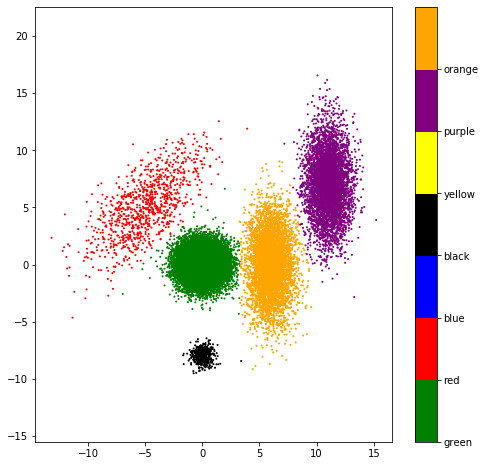

In [37]:
colors = ['green','red','blue','black','yellow','purple','orange']
x=X[:,0]
y=X[:,1]
fig = plt.figure(figsize=(8,8))
plt.scatter(x,y, c=labels, cmap=matplotlib.colors.ListedColormap(colors), s=1)
plt.axis('equal')
cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

In [38]:
testit = np.array([1,2,2,3])
testit[np.nonzero(testit>1)[0]], testit[np.where(testit>1)]

(array([2, 2, 3]), array([2, 2, 3]))